In [11]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [12]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4, ResNetFPN_8_2
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from source.visualization.training_visualization import plot_grad_flow_hist
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import time
import torch
from source.miscellaneous.evaluation import evaluate_model
from einops.einops import rearrange

In [13]:
torch.autograd.set_detect_anomaly(False)

In [15]:
crop_size = 640
affine_transformation_range = 0.25
perspective_transformation_range = 0.0001
patch_size = 16
max_translation_shift = 50
fine_height_width = (crop_size//patch_size)*4
coarse_height_width = crop_size//patch_size
images_directory = "../../data/cyto_downscaled_3344_3904/"
use_train_data = True

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    affine_transformation_range=affine_transformation_range,
    perspective_transformation_range=perspective_transformation_range,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_height_width=fine_height_width,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
)

In [16]:
from source.datasets.brain_dataset import collate_fn

In [17]:
batch_size = 2

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=False,
    collate_fn=collate_fn,
)

In [18]:
learning_rate = 0.0007
weight_decay = 0.0015
use_coarse_context = False
clamp_predictions = True
use_l2_with_standard_deviation = True
temperature = (
    0.2  # Dont decrease this value, it will yield in overflows (similarity_matrix)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
# block_dimensions_8_2 = [96, 128, 192]
# block_dimensions_16_4 = [64, 96, 128, 192]
block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]  # 1 for 16_4, 0 for 8_2
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).to(device=device)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).to(device=device)

coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(
    device=device
)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).to(device=device)
fine_matching = FineMatching(
    return_standard_deviation=use_l2_with_standard_deviation,
    clamp_predictions=clamp_predictions,
).to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters()) + list(fine_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [19]:
coarse_loss = "official_focal"
alpha = 0.65
gamma = 2.5
fine_loss = "l2_std" if use_l2_with_standard_deviation else "l2"

In [20]:
seen_datapoints = 0

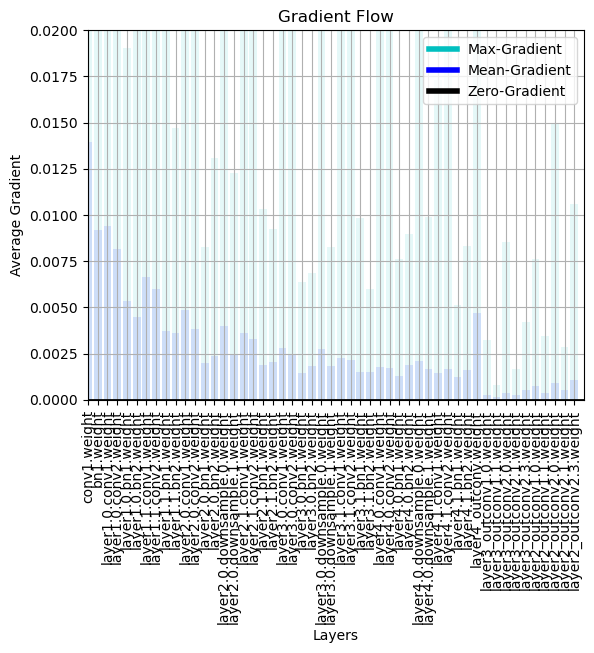

Epoch: 0, Duration: 17.10 sec, Latest Coarse Loss: 8.3864, Latest Fine Loss: 0.7535


In [21]:
print_frequency = 10
epochs = 1

for epoch in range(epochs):
    epoch_start_time = time.time()
    for (
        image_1_crop,
        image_2_crop,
        match_matrix,
        relative_coordinates,
        _,
    ) in dataloader_train:
        seen_datapoints += image_1_crop.shape[0]
        image_1_crop = image_1_crop.to(device=device)
        image_2_crop = image_2_crop.to(device=device)
        match_matrix = match_matrix.to(device=device)
        relative_coordinates = relative_coordinates.to(device=device)

        optimizer.zero_grad()

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)
        
        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after backbone. Breaking the training.")
            break
        
        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after positional_encoding. Breaking the training.")
            break

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after rearrange. Breaking the training.")
            break

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after coarse_loftr. Breaking the training.")
            break

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

        if coarse_matches["confidence_matrix"].isnan().any().item():
            print("coarse_matches['confidence_matrix'] contains NaN values. Breaking the training.")
            break

        coarse_matches_ground_truth = {
            "batch_indices": match_matrix.nonzero()[:, 0],
            "row_indices": match_matrix.nonzero()[:, 1],
            "column_indices": match_matrix.nonzero()[:, 2],
        }

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_ground_truth,
            fine_height_width=fine_height_width,
            coarse_height_width=coarse_height_width,
        )

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        predicted_relative_coordinates = fine_matching(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        if coarse_loss == "focal":
            coarse_loss_value = coarse_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "official_focal":
            coarse_loss_value = coarse_official_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "cross_entropy":
            coarse_loss_value = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
            )

        if fine_loss == "l2":
            fine_loss_value = fine_l2_loss(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        elif fine_loss == "l2_std":
            fine_loss_value = fine_l2_loss_with_standard_deviation(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        loss = coarse_loss_value + fine_loss_value
        loss.backward()

        # Adjust learning weights
        # torch.nn.utils.clip_grad_norm_(backbone.parameters(), 1.0)
        optimizer.step()

        coarse_loss_history.append(coarse_loss_value.cpu().item())
        fine_loss_history.append(fine_loss_value.cpu().item())

        if torch.isnan(coarse_matches["confidence_matrix"]).all():
            print(
                "coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training."
            )
            break
    if torch.isnan(coarse_matches["confidence_matrix"]).all():
        print(
            "coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training."
        )
        break

    epoch_duration = time.time() - epoch_start_time
    if epoch % print_frequency == 0 or epoch == (100 - 1):
        plot_grad_flow_hist(backbone.named_parameters())
        print(
            f"Epoch: {epoch}, Duration: {epoch_duration:.2f} sec, Latest Coarse Loss: {coarse_loss_value:.4f}, Latest Fine Loss: {fine_loss_value:.4f}"
        )

In [22]:
coarse_image_feature_1.shape, fine_image_feature_1.shape

(torch.Size([1, 1600, 192]), torch.Size([1, 96, 160, 160]))

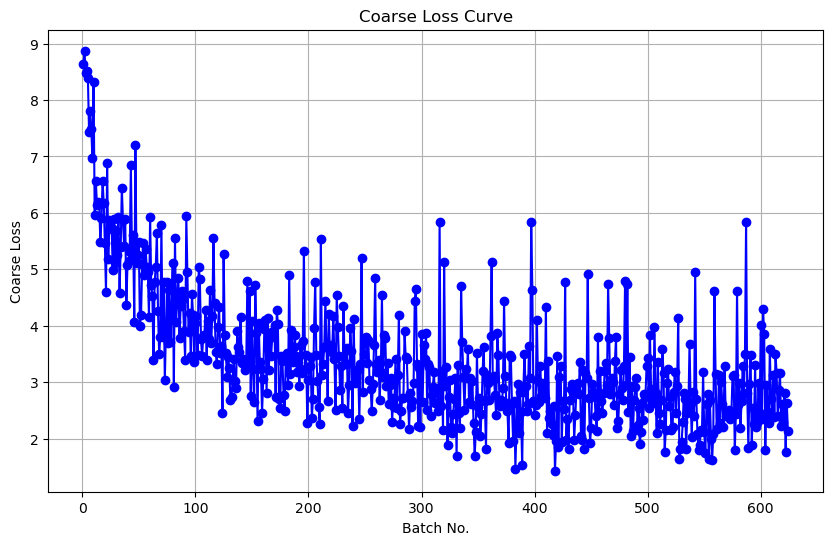

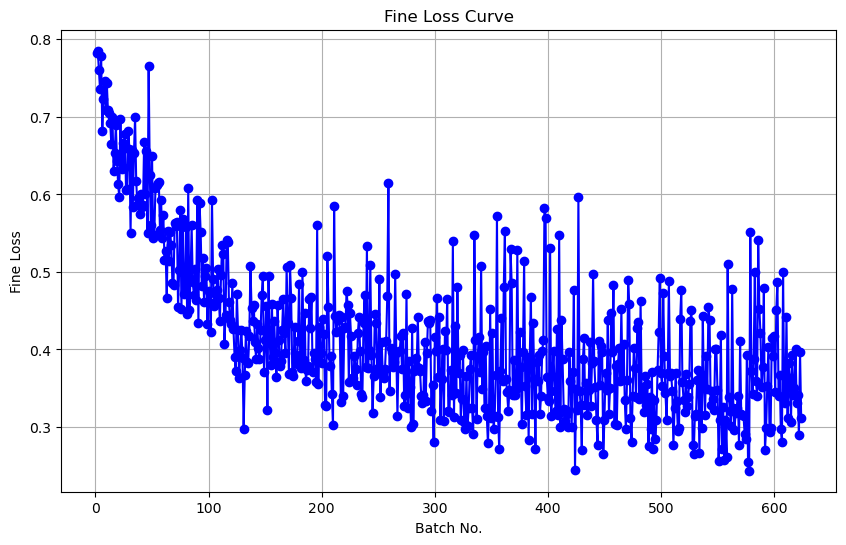

In [18]:
plot_loss_curve(coarse_loss_history, title="Coarse Loss Curve", ylabel="Coarse Loss")
plot_loss_curve(fine_loss_history, title="Fine Loss Curve", ylabel="Fine Loss")

In [19]:
from source.miscellaneous.model_saving import save_model

In [20]:
hyperparameters = {
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "coarse_context": use_coarse_context,
    "img_size": "3344_3904",
    "ResNet": backbone.__class__.__name__,
    "affine_transformation_range": affine_transformation_range,
    "perspective_transformation_range": perspective_transformation_range,
    "temperature": temperature,
    "batch_size": batch_size,
    "coarse_loss": coarse_loss,
    "fine_loss": fine_loss,
    "use_train_data": use_train_data,
    "clamp_predictions": clamp_predictions,
    "block_dimensions": block_dimensions,
    "use_l2_with_standard_deviation": use_l2_with_standard_deviation,
    "seen_datapoints": seen_datapoints,
    "crop_size": crop_size
    }

if coarse_loss == "focal":
    hyperparameters["gamma"] = gamma
    hyperparameters["alpha"] = alpha


models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
model_name = save_model(
    models,
    hyperparameters=hyperparameters,
    coarse_loss_history=coarse_loss_history,
    fine_loss_history=fine_loss_history,
)
model_name = model_name.split("/")[-1]

In [4]:
# patch_size=8
# crop_size=480

In [7]:
confidence_threshold = 0.9
block_dimensions = [64, 96, 128, 192]
temperature = 0.2
evaluation_metrics = evaluate_model(
    ["8"], [confidence_threshold], [block_dimensions], [temperature], patch_size=patch_size, crop_size=crop_size
)
evaluation_metrics

c:\Users\robin\Documents\HyperBrain\source\miscellaneous\evaluation.py:93: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/BucketizationUtils.h:34.)
  x_indices = torch.searchsorted(x_borders, x_coords) - 1


{'8': {'confidence_threshold': 0.9,
  'number_of_matches': 1066,
  'average_distance': 4.9084296226501465,
  'auc': 6.389409013912081,
  'entropy': 8.5608549118042,
  'matches_per_patch': [[0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0],
   [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
   

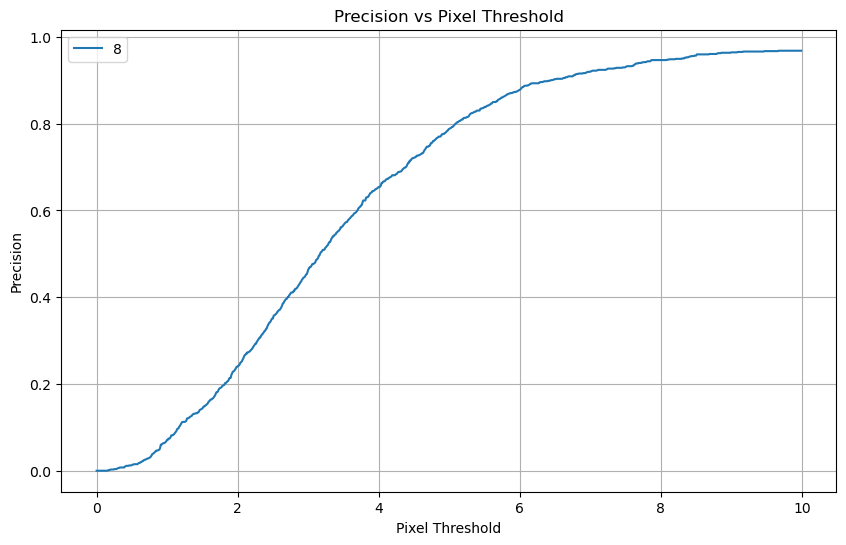

In [8]:
from source.visualization.evaluation_visualization import plot_precision_vs_threshold
plot_precision_vs_threshold(
    evaluation_metrics["8"]["match_precision"],
    labels=["8"],
)